In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
from inq_sgd import INQSGD
from inq_scheduler import INQScheduler, reset_lr_scheduler


In [6]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [7]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [8]:
def calculate_effective_bit_width(optimizer, full_precision_bits=32):
    total_elements = 0
    total_quantized_elements = 0
    
    for group in optimizer.param_groups:
        for idx, p in enumerate(group['params']):
            if p.requires_grad and group['Ts'][idx] is not None:
                total_elements += p.numel()
                # T == 0 means quantized
                total_quantized_elements += (group['Ts'][idx] == 0).sum().item()
    
    if total_elements == 0:
        return full_precision_bits # No trainable parameters or all are non-quantizable
    
    quantized_ratio = total_quantized_elements / total_elements
    weight_bits = group.get('weight_bits', full_precision_bits) # Get weight_bits from group, default to full_precision_bits if not set
    
    effective_bits = (quantized_ratio * weight_bits) + ((1 - quantized_ratio) * full_precision_bits)
    return effective_bits

In [9]:

# Existing train_epoch and evaluate_model functions (ensure they are defined)
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Ensure tqdm is correctly used as an iterable on dataloader
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def calculate_effective_bit_width(optimizer, full_precision_bits=32):
    total_elements = 0
    total_quantized_elements = 0
    
    for group in optimizer.param_groups:
        # Check if 'weight_bits' is even defined for the group
        if 'weight_bits' not in group or group['weight_bits'] is None:
            continue # Skip groups not subject to quantization

        for idx, p in enumerate(group['params']):
            # Ensure p.grad is not None and T is not None before trying to use T
            # T is the mask for trainable weights. If p.requires_grad is False, T will be None.
            if p.requires_grad and group['Ts'][idx] is not None:
                total_elements += p.numel()
                # T == 0 means quantized
                total_quantized_elements += (group['Ts'][idx] == 0).sum().item()
    
    if total_elements == 0:
        # If no trainable weights or all are excluded from INQ, return full_precision_bits
        # This handles cases like only BatchNorm layers being updated initially, or no weights being eligible.
        return full_precision_bits 
    
    quantized_ratio = total_quantized_elements / total_elements
    
    # Get the weight_bits specific to this INQ run from the optimizer's initial configuration
    # Assuming all relevant groups have the same 'weight_bits' set by INQSGD.
    # We can safely get it from the first group that has it, or pass it as an argument.
    # For robustness, we can ensure the `weight_bits` argument to INQSGD was passed.
    # The `weight_bits` variable from the main script scope is more reliable here.
    # No, it's better to get it from the optimizer group as that's where INQScheduler gets it from.
    # However, if some groups don't have 'weight_bits' set (e.g., if you had custom param groups),
    # this needs to be handled. For now, we assume the `weight_bits` from the main script is the target.
    
    # Using the weight_bits passed into the function, which should match the intended quantization bits.
    effective_bits = (quantized_ratio * weight_bits) + ((1 - quantized_ratio) * full_precision_bits)
    return effective_bits


# --- MAIN EXECUTION ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Data Loading and Preprocessing for MNIST
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Convert 1-channel to 3-channel
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST normalization (common values, yours was 0.1, 0.3)
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # 2. Model Initialization (ResNet-18)
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model = model.to(device)

    # 3. INQ Configuration
    iterative_steps = [0.5, 0.75, 1.0] # Quantize 50%, then 25% more, then final 25%
    inq_strategy = "pruning" # or "random"
    weight_bits = 4 # Example: 4-bit quantization
    full_precision_bits = 32 # Standard float32

    initial_lr = 0.01
    optimizer = INQSGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4, weight_bits=weight_bits)
    
    for group in optimizer.param_groups:
        group['initial_lr'] = group['lr']

    inq_scheduler = INQScheduler(optimizer, iterative_steps, strategy=inq_strategy)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    criterion = nn.CrossEntropyLoss()

    inq_steps_labels = ["Initial"] + [f"{int(s*100)}%" for s in iterative_steps]
    accuracy_history = []
    effective_bits_history = []

    # Initial evaluation before INQ
    print("\n--- Initial Evaluation (Full Precision) ---")
    loss, acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Initial Test Loss: {loss:.4f}, Initial Test Acc: {acc:.4f}")

    # Store initial metrics
    accuracy_history.append(acc)
    effective_bits_history.append(full_precision_bits) # Initially all 32-bit

    # INQ Training Loop
    fine_tune_epochs_per_inq_step = 2

    for inq_step_idx in range(len(iterative_steps)):
        print(f"\n--- INQ Step {inq_step_idx + 1}/{len(iterative_steps)} (Quantizing {iterative_steps[inq_step_idx]*100:.0f}% of weights) ---")

        # 1. Reset LR scheduler
        reset_lr_scheduler(lr_scheduler)

        # 2. Perform weight partitioning and quantization for the current INQ step
        inq_scheduler.step() # This calls `quantize()` internally

        # Evaluate immediately after quantization (before fine-tuning)
        print(f"--- Evaluation after INQ Step {inq_step_idx + 1} Quantization (before fine-tuning) ---")
        loss_after_quant, acc_after_quant = evaluate_model(model, test_loader, criterion, device)
        print(f"Test Loss: {loss_after_quant:.4f}, Test Acc: {acc_after_quant:.4f}")

        # Calculate and store effective bits after quantization (this is the state at the start of fine-tuning)
        # Note: The effective_bits_history here will reflect the bit-width *after* the quantization step
        # and *before* the subsequent fine-tuning. If you want the bit-width *after* fine-tuning of this step,
        # move this line after the fine-tuning loop, but the bit-width value won't change during fine-tuning.
        current_effective_bits = calculate_effective_bit_width(optimizer, full_precision_bits)
        print(f"Effective Bit-width after quantization: {current_effective_bits:.2f} bits")
        # You only append *once* per INQ step, after fine-tuning.

        # 3. Fine-tune the model
        print(f"--- Fine-tuning for {fine_tune_epochs_per_inq_step} epochs ---")
        for epoch in range(fine_tune_epochs_per_inq_step):
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
            test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
            lr_scheduler.step() # Step the LR scheduler within the fine-tuning loop
            print(f"Epoch {epoch+1}/{fine_tune_epochs_per_inq_step} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Test Loss: {test_acc:.4f}, Test Acc: {test_acc:.4f}") # Typo: should be Test Loss: {test_loss:.4f}
        
        print(f"--- Evaluation after INQ Step {inq_step_idx + 1} Fine-tuning ---")
        final_loss, final_acc = evaluate_model(model, test_loader, criterion, device)
        print(f"Final Test Loss: {final_loss:.4f}, Final Test Acc: {final_acc:.4f}")
        
        # Store accuracy and effective bits *after* fine-tuning for this step
        accuracy_history.append(final_acc)
        # The effective bit-width does not change during fine-tuning, only during the INQ scheduler's step().
        # So, appending `current_effective_bits` here is correct if you want to pair it with `final_acc`.
        effective_bits_history.append(current_effective_bits)

    # --- MOVE PLOTTING CODE HERE ---
    # This block should execute ONLY ONCE after the entire INQ loop is complete.
    print("\n--- INQ Procedure Completed ---")
    overall_final_test_loss, overall_final_test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Overall Final Test Loss: {overall_final_test_loss:.4f}, Overall Final Test Acc: {overall_final_test_acc:.4f}")

    print(f"DEBUG: len(inq_steps_labels)={len(inq_steps_labels)}")
    print(f"DEBUG: len(accuracy_history)={len(accuracy_history)}")
    print(f"DEBUG: len(effective_bits_history)={len(effective_bits_history)}")

Using device: cuda

--- Initial Evaluation (Full Precision) ---


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.90it/s]
c:\Users\Darian\anaconda3\envs\my_env\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
c:\Users\Darian\anaconda3\envs\my_env\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your

Initial Test Loss: 2.4044, Initial Test Acc: 0.1221

--- INQ Step 1/3 (Quantizing 50% of weights) ---
--- Evaluation after INQ Step 1 Quantization (before fine-tuning) ---


Evaluating: 100%|██████████| 79/79 [00:14<00:00,  5.45it/s]


Test Loss: 2.4997, Test Acc: 0.0892
Effective Bit-width after quantization: 18.00 bits
--- Fine-tuning for 2 epochs ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]


Epoch 1/2 - Train Loss: 0.0753, Train Acc: 0.9790 | Test Loss: 0.9943, Test Acc: 0.9943


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]


Epoch 2/2 - Train Loss: 0.0163, Train Acc: 0.9949 | Test Loss: 0.9953, Test Acc: 0.9953
--- Evaluation after INQ Step 1 Fine-tuning ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]


Final Test Loss: 0.0147, Final Test Acc: 0.9953

--- INQ Step 2/3 (Quantizing 75% of weights) ---
--- Evaluation after INQ Step 2 Quantization (before fine-tuning) ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]


Test Loss: 2.4346, Test Acc: 0.1135
Effective Bit-width after quantization: 8.57 bits
--- Fine-tuning for 2 epochs ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.24it/s]


Epoch 1/2 - Train Loss: 0.0667, Train Acc: 0.9879 | Test Loss: 0.9934, Test Acc: 0.9934


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]


Epoch 2/2 - Train Loss: 0.0160, Train Acc: 0.9958 | Test Loss: 0.9948, Test Acc: 0.9948
--- Evaluation after INQ Step 2 Fine-tuning ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


Final Test Loss: 0.0154, Final Test Acc: 0.9948

--- INQ Step 3/3 (Quantizing 100% of weights) ---
--- Evaluation after INQ Step 3 Quantization (before fine-tuning) ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


Test Loss: 1.7393, Test Acc: 0.4507
Effective Bit-width after quantization: 4.00 bits
--- Fine-tuning for 2 epochs ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]


Epoch 1/2 - Train Loss: 1.3034, Train Acc: 0.7147 | Test Loss: 0.7329, Test Acc: 0.7329


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


Epoch 2/2 - Train Loss: 1.3039, Train Acc: 0.7122 | Test Loss: 0.7388, Test Acc: 0.7388
--- Evaluation after INQ Step 3 Fine-tuning ---


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]


Final Test Loss: 1.2641, Final Test Acc: 0.7388

--- INQ Procedure Completed ---


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]

Overall Final Test Loss: 1.2641, Overall Final Test Acc: 0.7388
DEBUG: len(inq_steps_labels)=4
DEBUG: len(accuracy_history)=4
DEBUG: len(effective_bits_history)=4



--- Plotting Results ---


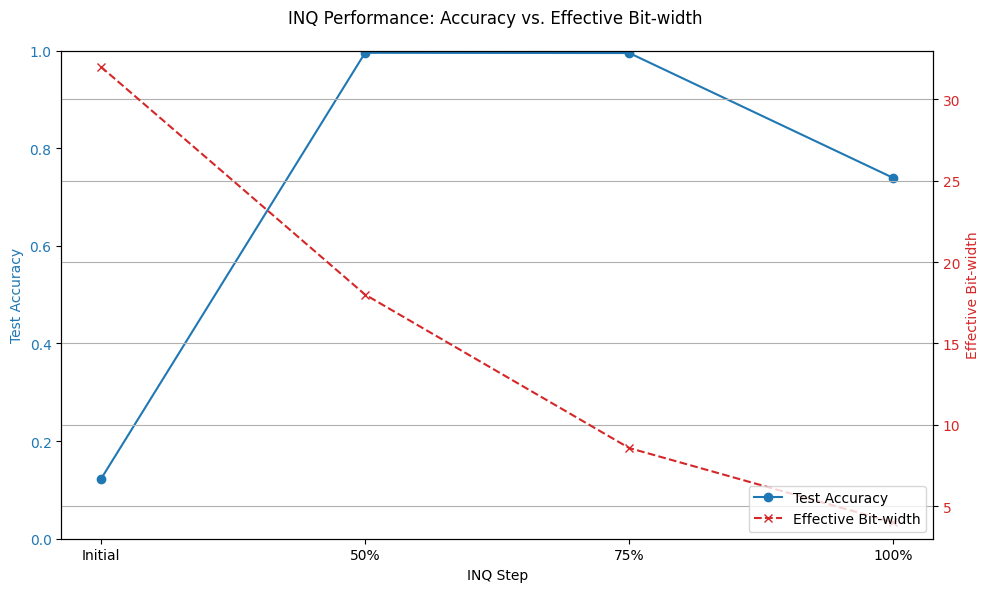

In [10]:
from matplotlib import pyplot as plt # Make sure this is imported
# Plotting the results
print("\n--- Plotting Results ---")

# Ensure inq_steps_labels matches the length of the collected data
# We collect initial + len(iterative_steps) results.
# So `inq_steps_labels` should have `1 + len(iterative_steps)` elements.


fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('INQ Step')
ax1.set_ylabel('Test Accuracy', color=color)
ax1.plot(inq_steps_labels, accuracy_history, marker='o', linestyle='-', color=color, label='Test Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.0, 1.0) # Accuracy range

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Effective Bit-width', color=color)
ax2.plot(inq_steps_labels, effective_bits_history, marker='x', linestyle='--', color=color, label='Effective Bit-width')
ax2.tick_params(axis='y', labelcolor=color)
# Set y-axis limits for bit-width. Max is 32, min is `weight_bits`
ax2.set_ylim(weight_bits - 1, full_precision_bits + 1) 

fig.suptitle('INQ Performance: Accuracy vs. Effective Bit-width')
fig.tight_layout() # otherwise the right y-label is slightly clipped

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

plt.grid(True)
plt.show()